# Feature Extracion and Pre-Processing

This is the first step of our work, on which we will utilize the yfinance library to gather the data we find useful for this task.

In this first instant it is necessary to make a decision about the development of our future model(s), so that we can extract and handle the correct data.<br>
This work can be approached in 2 different ways. We can:

- develop a **model for each company**. This approach allows for the detection of patterns within a singular company. It is a very tiring and intensive method, which requires time, computational power, and drive space.

- develop a **model that encompasses every company**. This approach allows for more general pattern recognition, which affect all companies aw once. It is more efficient and better at generalizing. 

Upon reflecting, we decided that the secong apporach is more useful for this task, since in real life, changes in certain stocks directly affect other stocks, and this can be useful for our model!

With this being said, we will create a single dataframe that contains, for each line, the values for a certain company at a certain day. The amount of sample will be given by the following equation:<br>
(days the stock market was open from 2010-02-01 to 2024-01-32 ) * (amount of S&P 500 companies)

This notebook is divided in the following parts:
- 0. Libraries
- 1. Feature Extraction and Feature Creation
- 2. Pre-Processing
- 3. Exploratory Data Analysis

# 

# 0. Libraries

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns

import yfinance as yf

from datetime import datetime, timedelta

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# 

# 1. Feature Extraction and Feature Creation

We now begin the feature extraction. The list of companies belonging to the S&P500 was taken from the Wikipedia (link below) and is up to date!

It is important to note that temporal features ("Date") can be interpreted in different forms by different models, according to the way they are extracted.<br>
In our case, we can handle "Date" in 3 different ways:
- separate in columns year/month/day (good for seasonal patterns);
- encode numerically, creating a chronological sequence (good for temporal evolution patterns);
- treat the year ciclically (good for periodical patterns of dates).

In hopes of detecting all diferent patterns this feature can provide, we decided to use all of these technics.<br>
Thus, we separated "Date" in 3 different columns (year/month/day), added a column that saves the number of days that have passed since 2010-02-01, and added 2 columns that save the sin and cossin of the day according to the year.

Moreover, the main feature we are going to focus on in our model is going to be the Close feature. Therefore, we will be adding a couple new features regarding Close.
- Moving Average (average price of close over the last n days, where n is 5 and 20;
- Volatility (risk through standard deviation of prices of close over the last n days, where n is 5);
- Rate of Change (percentage change of price of close over the last n days, where n is 5) 
- Lag (close values from the last n days, where n is 1 and 2).

Finally, we will also add the value of close from the day after, which we will use as our target in the future!

In [2]:
#url of the Wikipedia page that holds the table with the S&P 500 companies
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

#read the table
tables = pd.read_html(url)
sp500_df = tables[0]

#show the table
sp500_df

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
498,XYL,Xylem Inc.,Industrials,Industrial Machinery & Supplies & Components,"White Plains, New York",2011-11-01,1524472,2011
499,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
500,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
501,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927


In [3]:
#extract names and respective tickers
securities = sp500_df['Security'].tolist()
tickers = sp500_df['Symbol'].tolist()

In [4]:
#the tickers "BF.B" ("Brown-Forman") and "BRK.B" ("Berkshire Hathaway") were causing trouble, so we removed them

print("Before removal!")
print("Securities size:", len(securities))
print("Tickers size:", len(tickers))

if "BF.B" in tickers and "BRK.B" in tickers:
    tickers.remove("BF.B")
    tickers.remove("BRK.B")
    
if "Brown–Forman" in securities and "Berkshire Hathaway" in securities:
    securities.remove("Brown–Forman")
    securities.remove("Berkshire Hathaway")
    
print("\nAfter removal!")
print("Securities size:", len(securities))
print("Tickers size:", len(tickers))

Before removal!
Securities size: 503
Tickers size: 503

After removal!
Securities size: 501
Tickers size: 501


In [5]:
#if the extraction has already been done
if os.path.exists(os.path.join(os.getcwd(), "features/features_raw.pkl")):
    
    #open the saved dataframe in pickle format
    with open(os.path.join(os.getcwd(), "features/features_raw.pkl"), "rb") as ficheiro:
        dados = pickle.load(ficheiro)
    ficheiro.close()

    
#if the extraction is yet to be done 
else:
    
    #all the data
    dados = []
    
    #start date
    start_date = datetime(2010, 2, 1)

    for i in range(len(tickers)):

        #get the current ticker
        ticker = yf.Ticker(tickers[i])

        #get the dataframe of the ticker
        temp = ticker.history(period="max")

        #get dates (a little bit bigger than the desired dates so we can calculate the time-window features correctly)
        temp = temp.loc["2010-01-01 00:00:00-05:00": "2024-02-28 00:00:00-05:00"]

        #create time-window features
        #5-day moving average
        temp['MA_5'] = temp['Close'].rolling(window=5).mean()
        #20-day moving average
        temp['MA_20'] = temp['Close'].rolling(window=20).mean()
        #5-day volatility
        temp['VOL_5'] = temp['Close'].rolling(window=5).std()
        #5-day Rate of Change
        temp['ROC_5'] = (temp['Close'] - temp['Close'].shift(5)) / temp['Close'].shift(5) * 100    
        #1-day lag
        temp['LAG_1'] = temp['Close'].shift(1)
        #2-day lag
        temp['LAG_2'] = temp['Close'].shift(2)
        
        #NEXT DAY CLOSE (Y)
        temp['NEXT_DAY_CLOSE'] = temp['Close'].shift(-1)
        
        #get the desired dates
        temp = temp.loc["2010-02-01 00:00:00-05:00": "2024-01-31 00:00:00-05:00"]
        
        #create column with index (date)
        temp = temp.reset_index()
        temp.rename(columns={"index": "Date"}, inplace=True)

        #pass date as string
        temp['Date'] = temp['Date'].astype(str)
        temp['Date'] = temp['Date'].apply(lambda x: x.split(' ')[0])

        
        #features for every row
        for j in range(temp.shape[0]):

            #features
            year, month, day = list(map(int, temp['Date'][j].split('-')))
            ticker = tickers[i]
            security = securities[i]
            _open = temp['Open'][j]
            high = temp['High'][j]
            low = temp['Low'][j]
            close = temp['Close'][j]
            volume = temp['Volume'][j]
            dividends = temp['Dividends'][j]
            stock_splits = temp['Stock Splits'][j]

            #calculate days passed since (2010-02-01)
            current_date = datetime(year, month, day)
            dif_days = current_date - start_date
            day_num = dif_days.days

            #calculate sin and cossin of day
            day_sin = np.sin(2*np.pi*day/365)
            day_cos = np.cos(2*np.pi*day/365)
            
            #get the time-window features
            ma_5 = temp['MA_5'][j]
            ma_20 = temp['MA_20'][j]
            vol_5 = temp['VOL_5'][j]
            roc_5 = temp['ROC_5'][j]
            lag_1 = temp['LAG_1'][j]
            lag_2 = temp['LAG_2'][j]
            
            #get the next day close
            next_day_close = temp['NEXT_DAY_CLOSE'][j]
            

            
            #append current data
            dados.append({
                "Year": year,
                "Month": month,
                "Day": day,
                "Day_num": day_num,
                "Day_sin": day_sin,
                "Day_cos": day_cos,
                "Ticker": ticker,
                "Security": security,
                "Ticker_code": i,
                "Open": _open,
                "High": high,
                "Low": low,
                "Close": close,
                "Volume": volume,
                "Dividends": dividends,
                "Stock_splits": stock_splits,
                "Moving_average_5": ma_5,
                "Moving_average_20": ma_20,
                "Volatility_5": vol_5,
                "Rate_of_change_5": roc_5,
                "Lag_1": lag_1,
                "Lag_2": lag_2,
                "Next_day_close": next_day_close
            })

    #transform list into ataframe
    dados = pd.DataFrame(dados)
    
    #save dataframe in pickle
    with open(os.path.join(os.getcwd(), "features/features_raw.pkl"), "wb") as ficheiro:
        pickle.dump(dados, ficheiro)
    ficheiro.close()

In [6]:
dados

,Year,Month,Day,Day_num,Day_sin,Day_cos,Ticker,Security,Ticker_code,Open,...,Volume,Dividends,Stock_splits,Moving_average_5,Moving_average_20,Volatility_5,Rate_of_change_5,Lag_1,Lag_2,Next_day_close
0,2010,2,1,0,0.017213,0.999852,MMM,3M,0,42.634167,...,4344709,0.0,0.0,42.782890,43.704234,0.429154,-1.698659,42.449585,42.586708,42.417927
1,2010,2,2,1,0.034422,0.999407,MMM,3M,0,42.560323,...,5609240,0.0,0.0,42.656317,43.635936,0.423679,-1.470045,42.423210,42.449585,42.982235
2,2010,2,3,2,0.051620,0.998667,MMM,3M,0,42.101493,...,4067955,0.0,0.0,42.571933,43.609566,0.239464,-0.972075,42.417927,42.423210,41.774513
3,2010,2,4,3,0.068802,0.997630,MMM,3M,0,42.787103,...,6353870,0.0,0.0,42.409494,43.491958,0.428106,-1.907156,42.982235,42.417927,41.421169
4,2010,2,5,4,0.085965,0.996298,MMM,3M,0,41.748151,...,6467968,0.0,0.0,42.203811,43.355101,0.611709,-2.422675,41.774513,42.982235,40.888508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1665611,2024,1,25,5106,0.417194,0.908818,ZTS,Zoetis,500,184.127167,...,2530600,0.0,0.0,186.790891,191.818037,1.879924,-1.669294,184.663101,186.677765,190.071899
1665612,2024,1,26,5107,0.432776,0.901502,ZTS,Zoetis,500,187.779368,...,1840200,0.0,0.0,187.414142,191.573182,2.394375,1.666843,185.903641,184.663101,191.302521
1665613,2024,1,29,5110,0.478734,0.877960,ZTS,Zoetis,500,189.913112,...,1669900,0.0,0.0,187.723785,191.376985,2.832660,0.815907,190.071899,185.903641,189.982559
1665614,2024,1,30,5111,0.493776,0.869589,ZTS,Zoetis,500,191.411674,...,1607500,0.0,0.0,188.384744,191.104395,2.912019,1.770320,191.302521,190.071899,186.389954


# 

# 2. Pre-Processing

We will now clean the data we extracted, assess it's quality and normalize it.

In [7]:
dados_processed = dados.copy()
del dados

###### Null Values
As we can see, for companies that were later added to the S&P500, some metrics we calculated are missing! Since it is a tiny fraction of our sample space, we will fill the null values with zeros!

In [8]:
#first, we check for null values
dados_processed.isnull().sum()

Year                    0
Month                   0
Day                     0
Day_num                 0
Day_sin                 0
Day_cos                 0
Ticker                  0
Security                0
Ticker_code             0
Open                    0
High                    0
Low                     0
Close                   0
Volume                  0
Dividends               0
Stock_splits            0
Moving_average_5      272
Moving_average_20    1293
Volatility_5          272
Rate_of_change_5      340
Lag_1                  68
Lag_2                 136
Next_day_close          0
dtype: int64

In [9]:
#replace NaN values with zeros for new features
dados_processed.fillna(0, inplace=True)

###### Duplicated Rows

Since our extraction was succesfull, we can see that there are no duplicated rows!

In [10]:
#we now check for duplicate rows
dados_processed.duplicated().sum()

0

###### Normalization

We can now finally proceed to the data normalization process! We will use different types of normalization according to our fatures!<br>
MinMaxScaler will be used for features that have bounded ranges, while StandardScaler will be used for features with unbounded ranged. RobustScaler will be used for features with outliers. Categorical features will not be normalized.

A quick overview:
- Year (MinMax)
- Month (None)
- Day (None)            
- Day_num (MinMax)              
- Day_sin (None)        
- Day_cos (None)          
- Ticker (None)          
- Security (None)            
- Ticker_code (None)         
- Open (StandardScaling)      
- High (StandardScaling)                      
- Low (StandardScaling)   
- Close (StandardScaling)   
- Volume (MinMax)
- Dividends (RobustScaling)         
- Stock_splits (None)
- Moving_average_5 (StandardScaling) 
- Moving_average_20 (StandardScaling) 
- Volatility_5 (StandardScaling)     
- Rate_of_change_5 (StandardScaling)  
- Lag_1 (StandardScaling)         
- Lag_2 (StandardScaling)

- Next_day_close (StandardScaling)

In [11]:
#MinMax normalization for features that have bounded ranges!
minmaxscaler = MinMaxScaler()
dados_processed["Year"] = minmaxscaler.fit_transform(dados_processed[["Year"]])
dados_processed["Day_num"] = minmaxscaler.fit_transform(dados_processed[["Day_num"]])
dados_processed["Volume"] = minmaxscaler.fit_transform(dados_processed[["Volume"]])

#we were going to use StandardScaler for price-related features
#but in the portfolio part it got tricky to know which prices went up, and which prices went down!
#hence we used minmax for this type of features! the results did not get worse :)
dados_processed["Open"] = minmaxscaler.fit_transform(dados_processed[["Open"]])
dados_processed["High"] = minmaxscaler.fit_transform(dados_processed[["High"]])
dados_processed["Low"] = minmaxscaler.fit_transform(dados_processed[["Low"]])
dados_processed["Close"] = minmaxscaler.fit_transform(dados_processed[["Close"]])
dados_processed["Moving_average_5"] = minmaxscaler.fit_transform(dados_processed[["Moving_average_5"]])
dados_processed["Moving_average_20"] = minmaxscaler.fit_transform(dados_processed[["Moving_average_20"]])
dados_processed["Volatility_5"] = minmaxscaler.fit_transform(dados_processed[["Volatility_5"]])
dados_processed["Rate_of_change_5"] = minmaxscaler.fit_transform(dados_processed[["Rate_of_change_5"]])
dados_processed["Lag_1"] = minmaxscaler.fit_transform(dados_processed[["Lag_1"]])
dados_processed["Lag_2"] = minmaxscaler.fit_transform(dados_processed[["Lag_2"]])

#dados_processed["Next_day_close"] = minmaxscaler.fit_transform(dados_processed[["Next_day_close"]])

In [12]:
#StandardScaler normalization for features with unbounded ranges!
#standardscaler = StandardScaler()
#dados_processed["Open"] = standardscaler.fit_transform(dados_processed[["Open"]])
#dados_processed["High"] = standardscaler.fit_transform(dados_processed[["High"]])
#dados_processed["Low"] = standardscaler.fit_transform(dados_processed[["Low"]])
#dados_processed["Close"] = standardscaler.fit_transform(dados_processed[["Close"]])
#dados_processed["Moving_average_5"] = standardscaler.fit_transform(dados_processed[["Moving_average_5"]])
#dados_processed["Moving_average_20"] = standardscaler.fit_transform(dados_processed[["Moving_average_20"]])
#dados_processed["Volatility_5"] = standardscaler.fit_transform(dados_processed[["Volatility_5"]])
#dados_processed["Rate_of_change_5"] = standardscaler.fit_transform(dados_processed[["Rate_of_change_5"]])
#dados_processed["Lag_1"] = standardscaler.fit_transform(dados_processed[["Lag_1"]])
#dados_processed["Lag_2"] = standardscaler.fit_transform(dados_processed[["Lag_2"]])

#dados_processed["Next_day_close"] = standardscaler.fit_transform(dados_processed[["Next_day_close"]])

In [13]:
#RobustScaler normalization for features with outliers!
robustscaler = RobustScaler()
dados_processed["Dividends"] = robustscaler.fit_transform(dados_processed[["Dividends"]])

###### IMPORTANT NOTE
we ended up not normalizing the target (Next_day_close), so the portfolio optimization step could be more realistic (no need to inverse the scaling, allowing for direct calculation of the expected profit)! The performance of our models was not significally changed, so we believe this alteration was for the better!<br>
We also used MinMaxScaler for the price-related features, for similar reasons. StandardScaler changes values to negative and positive values, which makes the expcted profit calculation really harder. We opted for a MinMaxScaler approach, which made that part easier since it changes the values from 0 to 1.

###### Selecting Columns

Some columns do not provide useful information. We will now drop these columns to avoid confusion.

In [14]:
dados_processed = dados_processed.drop(columns=['Ticker', 'Security'])

In [15]:
dados_processed

,Year,Month,Day,Day_num,Day_sin,Day_cos,Ticker_code,Open,High,Low,...,Volume,Dividends,Stock_splits,Moving_average_5,Moving_average_20,Volatility_5,Rate_of_change_5,Lag_1,Lag_2,Next_day_close
0,0.0,2,1,0.000000,0.017213,0.999852,0,0.005761,0.005719,0.005782,...,0.001176,0.0,0.0,0.005930,0.006167,0.000791,0.337381,0.005724,0.005743,42.417927
1,0.0,2,2,0.000196,0.034422,0.999407,0,0.005751,0.005722,0.005765,...,0.001519,0.0,0.0,0.005912,0.006158,0.000781,0.338488,0.005720,0.005724,42.982235
2,0.0,2,3,0.000391,0.051620,0.998667,0,0.005689,0.005775,0.005774,...,0.001102,0.0,0.0,0.005901,0.006154,0.000442,0.340901,0.005720,0.005720,41.774513
3,0.0,2,4,0.000587,0.068802,0.997630,0,0.005782,0.005736,0.005702,...,0.001721,0.0,0.0,0.005878,0.006137,0.000790,0.336371,0.005796,0.005720,41.421169
4,0.0,2,5,0.000782,0.085965,0.996298,0,0.005641,0.005620,0.005588,...,0.001751,0.0,0.0,0.005850,0.006118,0.001128,0.333873,0.005633,0.005796,40.888508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1665611,1.0,1,25,0.998826,0.417194,0.908818,500,0.024971,0.025043,0.025316,...,0.000685,0.0,0.0,0.025890,0.027069,0.003467,0.337523,0.024901,0.025172,190.071899
1665612,1.0,1,26,0.999022,0.432776,0.901502,500,0.025467,0.025758,0.025817,...,0.000498,0.0,0.0,0.025976,0.027034,0.004416,0.353686,0.025068,0.024901,191.302521
1665613,1.0,1,29,0.999609,0.478734,0.877960,500,0.025757,0.025774,0.025952,...,0.000452,0.0,0.0,0.026019,0.027006,0.005224,0.349563,0.025630,0.025068,189.982559
1665614,1.0,1,30,0.999804,0.493776,0.869589,500,0.025960,0.025842,0.026018,...,0.000435,0.0,0.0,0.026111,0.026968,0.005371,0.354187,0.025796,0.025630,186.389954


###### Saving the Dataframe

In order to use this final processed dataframe, we will save it in pickle!

In [16]:
if not os.path.exists(os.path.join(os.getcwd(), "features/features_processed.pkl")):    
    #save dataframe in pickle
    with open(os.path.join(os.getcwd(), "features/features_processed.pkl"), "wb") as ficheiro:
        pickle.dump(dados_processed, ficheiro)
    ficheiro.close()

# 

# 3. Exploratory Data Analysis

Before we move on to our model, we will quickly explain what our features symbolize and why we decided to use them!<br>
We will then plot soe graphs and try to understand if any particular feature is more related to the behaviour of our target.

We were left with the following features:
- Year, represents the year of te observation (good for chronological evolution patterns);
- Month, represents the month of the observation (good for yearly patterns);
- Day, represents the day of the observation (good for monthly patterns);           
- Day_num, counts how many days have passed since 2010-02-01 (good for chronological evolution patterns);         
- Day_sin, represents how close/far it is from the end/beggining of the year (good for cyclical patterns);       
- Day_cos, represents how close/far it is from the end/beggining of the year (good for cyclical patterns);       
- Ticker_code, refers to a single company (good for recognition of trends inside companies);      
- Open, price when the stock market opened that day (relates to high, low, close);
- High, highest price that day (relates to open, low, close);                       
- Low, lowest price that day (relates to open, high, close);   
- Close, price when the stock market closed that day (relates to open, high, low);    
- Volume, how many stocks there are (good to know how big the company is);
- Dividends, how much the stock pays to the investors (different values for every company); 
- Stock_splits, says if the stock was splitted that day (may be related to change in prices);
- Moving_average_5, how the closing price has changed in the last 5 days (detects recent trends);
- Moving_average_20, how the closing price has changed in the last 20 days (detects almost-monthly trends); 
- Volatility_5, referes to degree of variation/risk in the price over the last 5 days (helps to know if it is risky or not to buy);
- Rate_of_change_5, calculates how the closing price differs from 5 days ago (good to detect rapidly increasing/decreasing prices);
- Lag_1, closing price from day before (will likely be similar to current closing price);
- Lag_2, closing price from 2 days prior (will likely be similar to lag_1);


- Next_day_close, closing price from the next day (what we will predict)

In [17]:
#open the saved dataframe in pickle format
with open(os.path.join(os.getcwd(), "features/features_raw.pkl"), "rb") as ficheiro:
    features_eda = pickle.load(ficheiro)
ficheiro.close()

In [18]:
companies = ["AAPL", "GOOG", "KO"]
features_companies = features_eda[features_eda["Ticker"].isin(companies)]

###### Closing Price Over Time

Using 3 different companies (Apple, Google, Coca-Cola), we will plot the closing price throughout the days since 2010-02-01, using as x-axis the feature "Day_num", which counts how many days have passed since that date!

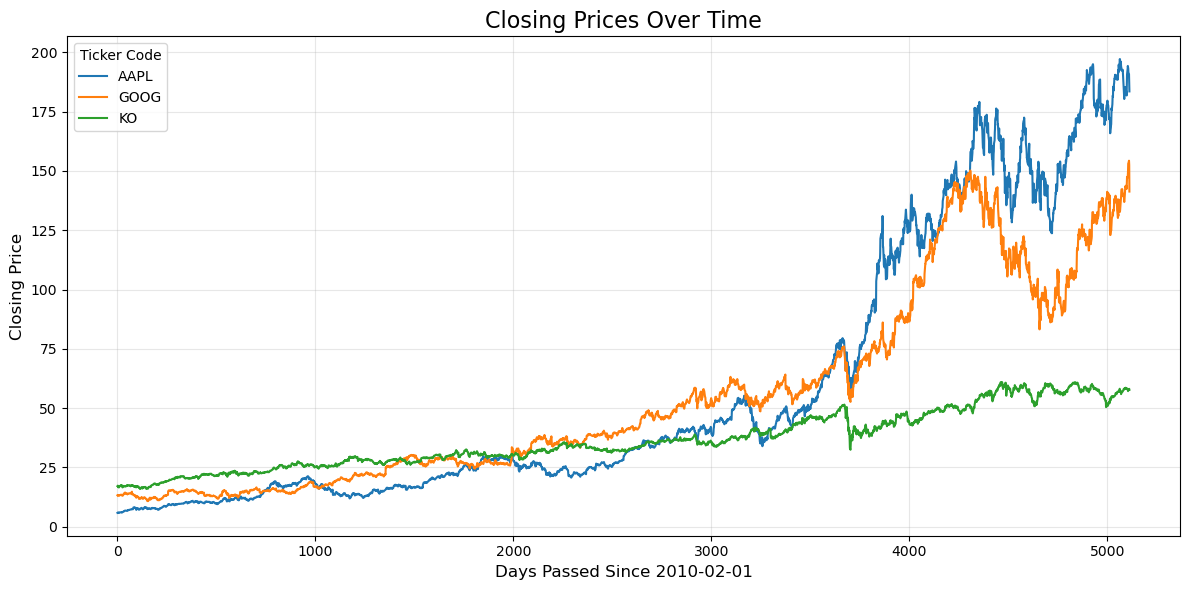

In [19]:
plt.figure(figsize=(12, 6))

for company in companies:
    
    company_data = features_companies[features_companies["Ticker"] == company]
    plt.plot(company_data["Day_num"], company_data["Close"], label=company)

plt.title("Closing Prices Over Time", fontsize=16)
plt.xlabel("Days Passed Since 2010-02-01", fontsize=12)
plt.ylabel("Closing Price", fontsize=12)
plt.legend(title="Ticker Code")
plt.grid(alpha=0.3)
plt.tight_layout()

plt.show()

###### Lag and Closing Price

We will now see, only for AAPL, how Lag_1 and Lag_2 influence the Next_day_close feature!

This will only be done for more than 5000 days since the start date, so we can see the results more clearly!

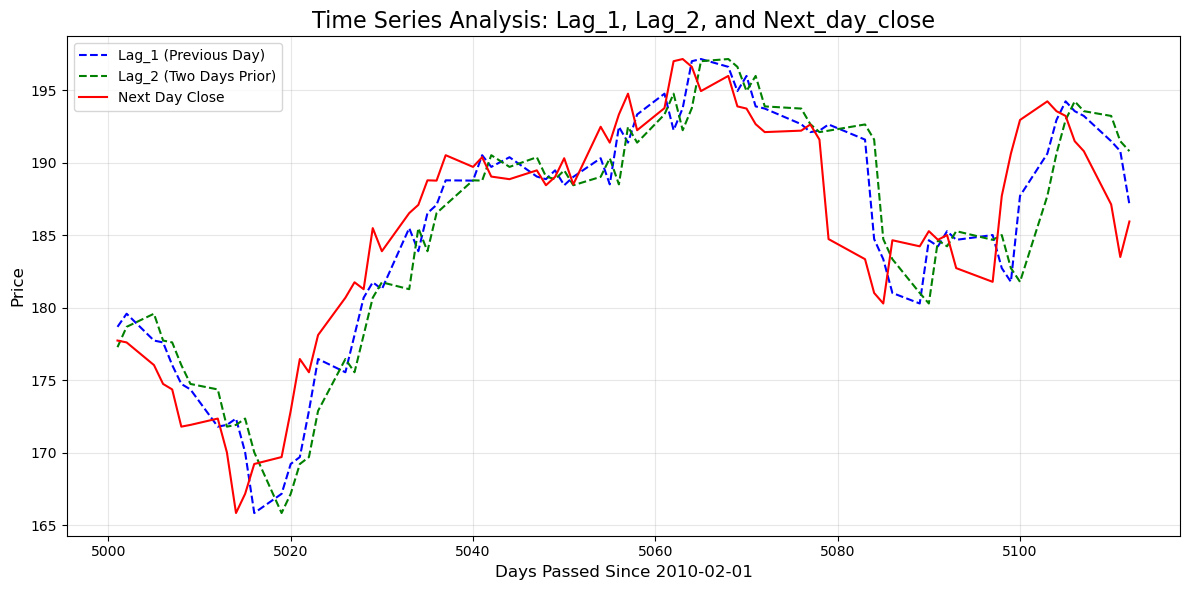

In [20]:
# Plotting
plt.figure(figsize=(12, 6))

temp_company = features_eda[features_eda["Ticker"]=="AAPL"]
temp_company = temp_company[temp_company["Day_num"]>5000]

# Plot Lag_1, Lag_2, and Next_day_close
plt.plot(temp_company["Day_num"], temp_company["Lag_1"], label="Lag_1 (Previous Day)", linestyle="--", color="blue")
plt.plot(temp_company["Day_num"], temp_company["Lag_2"], label="Lag_2 (Two Days Prior)", linestyle="--", color="green")
plt.plot(temp_company["Day_num"], temp_company["Next_day_close"], label="Next Day Close", color="red")

# Customize plot
plt.title("Time Series Analysis: Lag_1, Lag_2, and Next_day_close", fontsize=16)
plt.xlabel("Days Passed Since 2010-02-01", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

# Show plot
plt.show()

###### Correlation Between Features

We will now plot the average correlation between features, which tells us how some features influence others!<br>
We can see there are a lot of features influencing eachother

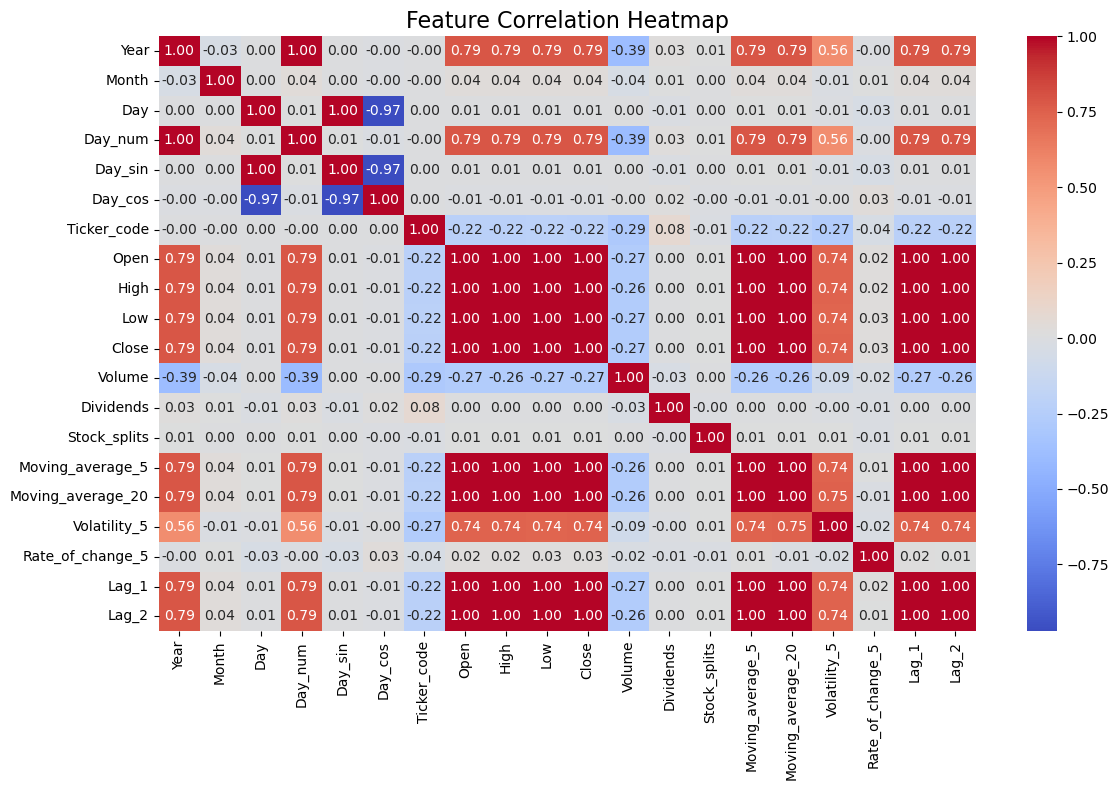

In [21]:
# Compute the correlation matrix
correlation_matrix = features_companies.drop(columns="Next_day_close").corr()

# Visualize the correlation matrix with a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Feature Correlation Heatmap", fontsize=16)
plt.tight_layout()
plt.show()

###### Correlation Between Features and Label

We will now plot the average correlation between features and label, which tells us how some features influence the label!<br>
We can see that our target (Next_day_close) is highly related to features like Open, High, Low, Close, Moving_average_5, Moving_average_20, Volatility_5, Lag_1, Lag_2 and Day_num.

We might exclude all other features and leave just these later!

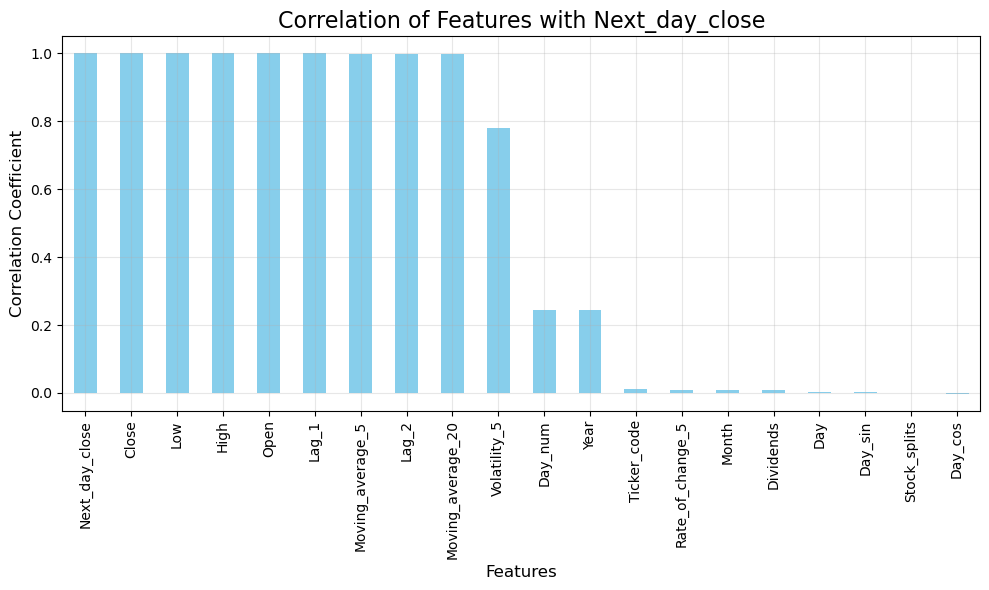

In [22]:
# Calculate correlations with the label (Next_day_close)
correlations =features_eda.corr()["Next_day_close"].sort_values(ascending=False)

# Visualize correlations with a bar plot
plt.figure(figsize=(10, 6))
correlations[:-1].plot(kind='bar', color='skyblue')  # Exclude self-correlation
plt.title("Correlation of Features with Next_day_close", fontsize=16)
plt.xlabel("Features", fontsize=12)
plt.ylabel("Correlation Coefficient", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()

# Show the plot
plt.show()

###### Overall Price and Time-Window Features Evolution

Now we will look at the stock prices in a more general way!<br>
We will see how closing prices, moving averages and volatilities, when grouped by year, behave. The similar plots show an overall growth!

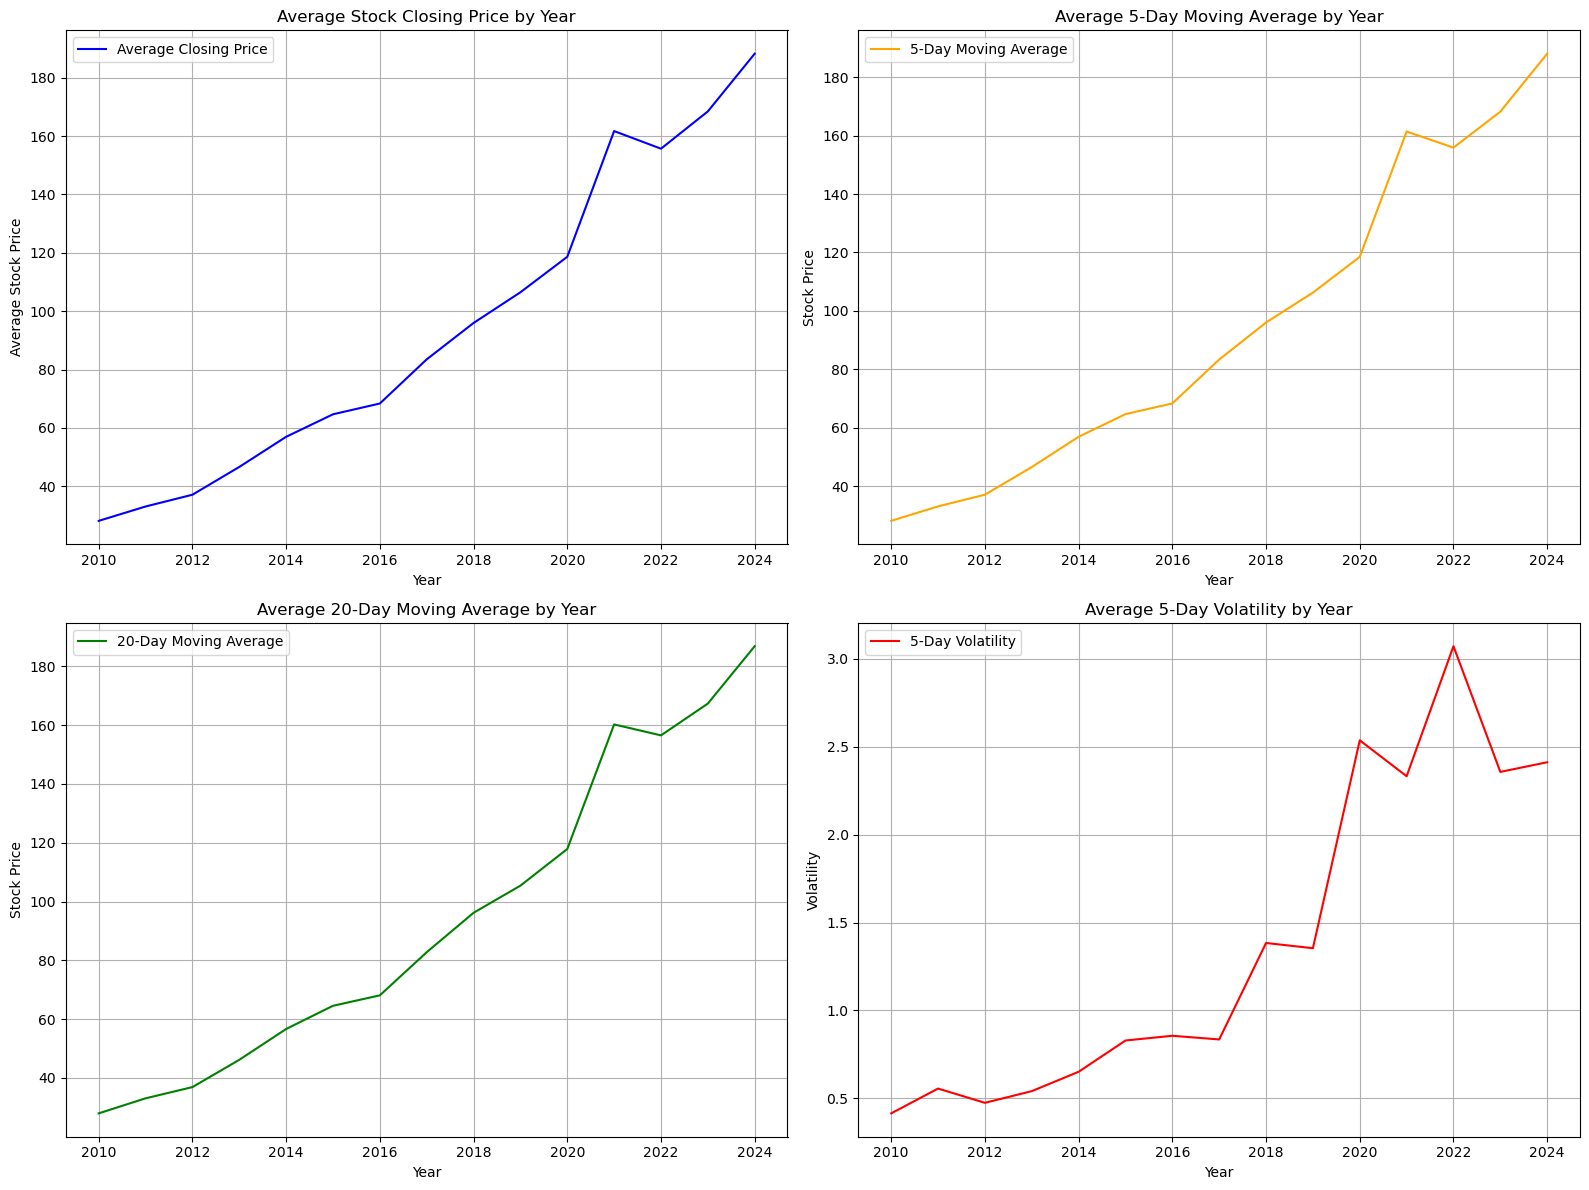

In [23]:
# Set the figure size and layout
fig, axes = plt.subplots(2, 2, figsize=(16, 12))  # 2 rows, 2 columns

# 1. Time Series of Stock Prices (by Year)
axes[0, 0].plot(
    features_eda.groupby('Year')['Close'].mean(), 
    label='Average Closing Price', 
    color='blue'
)
axes[0, 0].set_title('Average Stock Closing Price by Year')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Average Stock Price')
axes[0, 0].legend()
axes[0, 0].grid(True)

# 2. Moving Averages (5-day and 20-day) (by Year)
axes[0, 1].plot(
    features_eda.groupby('Year')['Moving_average_5'].mean(), 
    label='5-Day Moving Average', 
    color='orange'
)
axes[0, 1].set_title('Average 5-Day Moving Average by Year')
axes[0, 1].set_xlabel('Year')
axes[0, 1].set_ylabel('Stock Price')
axes[0, 1].legend()
axes[0, 1].grid(True)

axes[1, 0].plot(
    features_eda.groupby('Year')['Moving_average_20'].mean(), 
    label='20-Day Moving Average', 
    color='green'
)
axes[1, 0].set_title('Average 20-Day Moving Average by Year')
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Stock Price')
axes[1, 0].legend()
axes[1, 0].grid(True)

# 3. Volatility (5-day volatility) (by Year)
axes[1, 1].plot(
    features_eda.groupby('Year')['Volatility_5'].mean(), 
    label='5-Day Volatility', 
    color='red'
)
axes[1, 1].set_title('Average 5-Day Volatility by Year')
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Volatility')
axes[1, 1].legend()
axes[1, 1].grid(True)

# Adjust spacing between plots
plt.tight_layout()

# Display the plots
plt.show()

###### Stock Price Distribution by Year

Lastly, we have the stock price distibution grouped by year.<br>
We can clearly see a growth in overall stock price, paired with a growing disparity in individual stock prices!

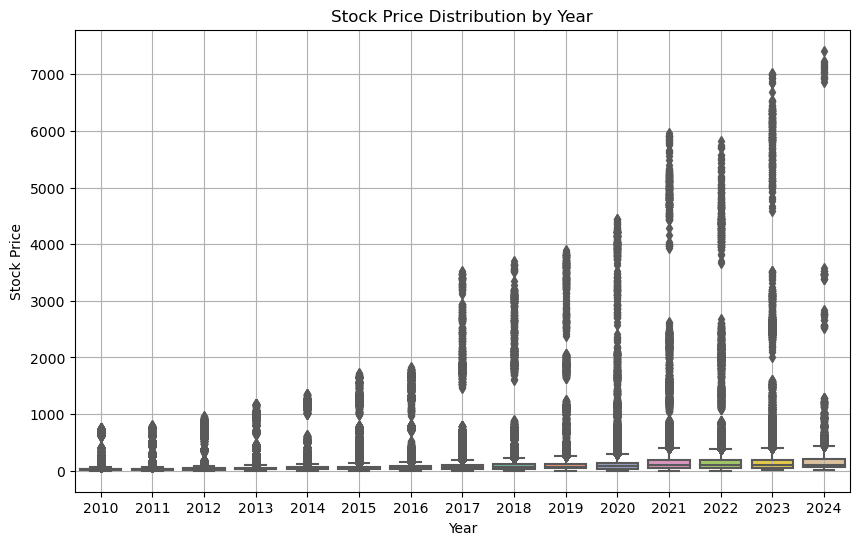

In [24]:
# 7. Distribution of Stock Prices (by Year)
plt.figure(figsize=(10, 6))
# Plotting the distribution of closing prices, aggregated by year
sns.boxplot(x='Year', y='Close', data=features_eda, palette='Set2')
plt.title('Stock Price Distribution by Year')
plt.xlabel('Year')
plt.ylabel('Stock Price')
plt.grid(True)
plt.show()